# Classification. Linear models and KNN

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [913]:
data = pd.read_csv(os.path.join('./titanic/', 'train.csv')).set_index('PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

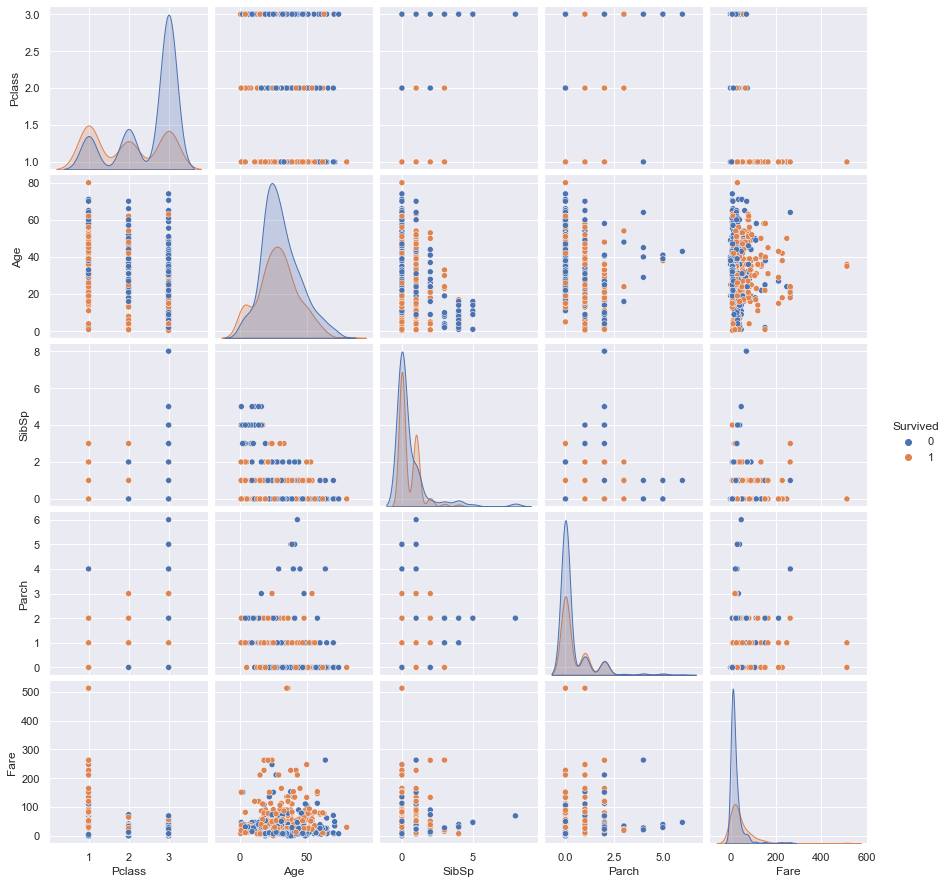

In [914]:
sns.pairplot(data, hue='Survived')

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

There are 577 males and 314 females in the dataset


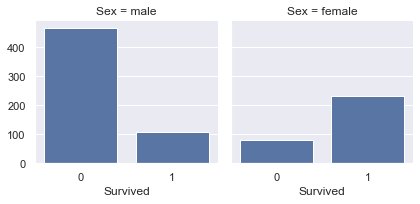

In [915]:
print('There are {} males and {} females in the dataset'.format(*tuple(data['Sex'].value_counts())))
sns.FacetGrid(data, col="Sex").map(sns.countplot, "Survived", order=None);

In [916]:
survived_proportion = data[data['Survived']==1]['Sex'].value_counts() / data['Sex'].value_counts()
print('percentage of male survivors:', np.round(survived_proportion[1]*100,2))
print('percentage of female survivors:', np.round(survived_proportion[0]*100,2))

percentage of male survivors: 18.89
percentage of female survivors: 74.2


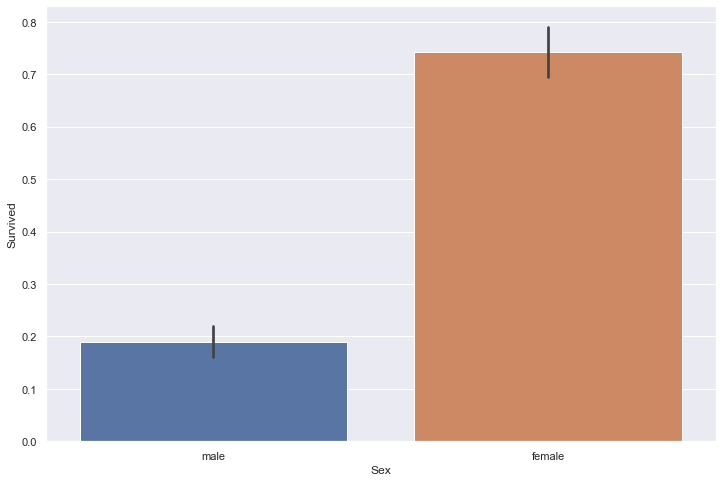

In [324]:
# Тоже самое в графическом виде
sns.barplot(x = "Sex", y = "Survived", data = data);

Очевидно, у женщин шансов больше.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

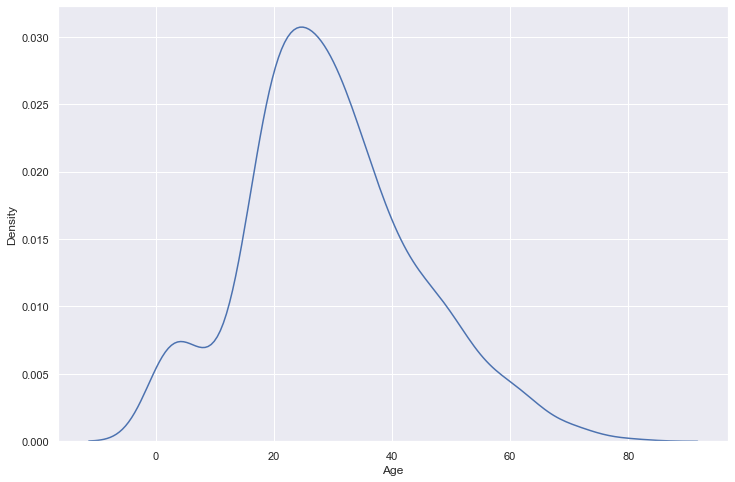

In [325]:
sns.kdeplot(data['Age'], label = 'all passengers');

Average age of deceased passengers 30.63, survived passengers 28.34
Median age of deceased passengers 28.0, survived passengers 28.0


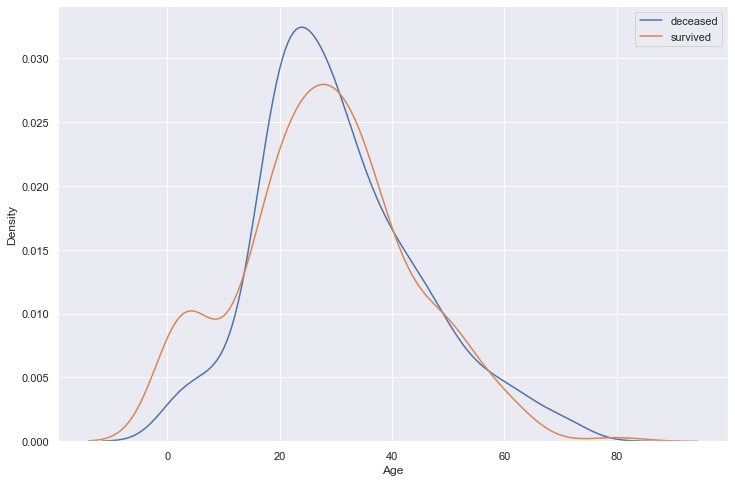

In [326]:
print('Average age of deceased passengers {}, survived passengers {}'
      .format(*np.round(data.groupby(['Survived'])['Age'].mean(), 2)))
print('Median age of deceased passengers {}, survived passengers {}'
      .format(*np.round(data.groupby(['Survived'])['Age'].median(), 2)))
sns.kdeplot(data[data['Survived']==0]['Age'], label = 'deceased')
sns.kdeplot(data[data['Survived']==1]['Age'], label = 'survived')
plt.legend()
sns.set(rc={'figure.figsize':(12,8)})

Распределения немного отличаются. Судя по ним: если вам меньше 10 лет, ваши шансы выжить на Титанике поышаются, а если от примерно 20 до 30 или от 70 до 80 - скорее наоборот.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

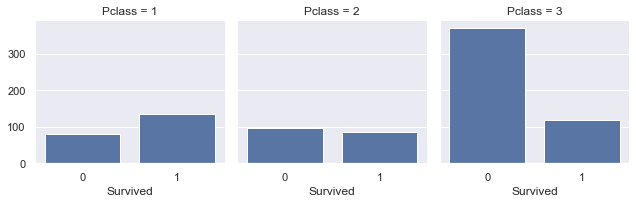

In [327]:
sns.FacetGrid(data, col="Pclass").map(sns.countplot, "Survived", order=None);

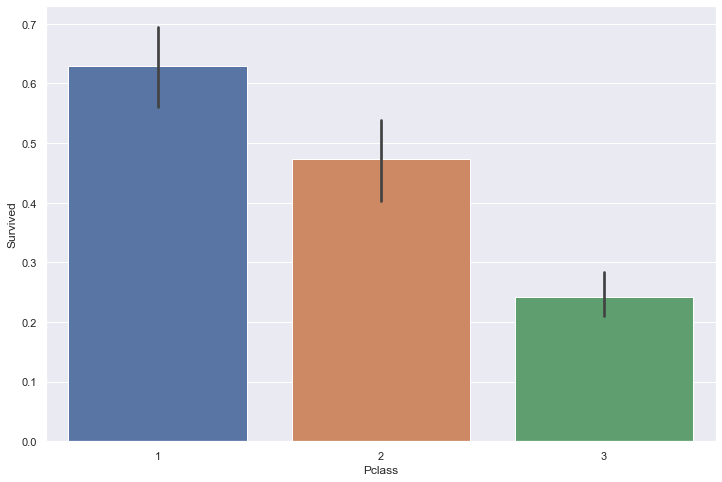

In [328]:
sns.barplot(x = "Pclass", y = "Survived", data = data);

Класс заметно влияет(или как минимум коррелирует) на выживаемость. Чем выше, тем лучше.

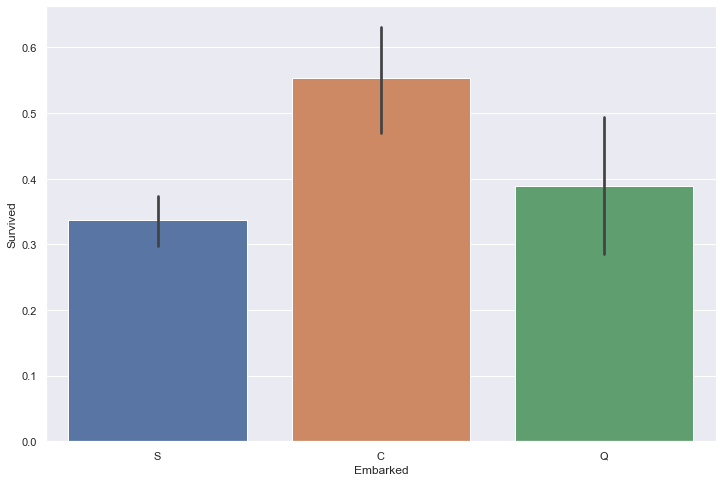

In [330]:
sns.barplot(x = "Embarked", y = "Survived", data = data);

Вроде бы посадка в Шербуре(сейчас Шербур-Октевиль) тоже повышает шансы выжить. Но есть ли здесь связь на самом деле. Может так совпало, что там сели наиболее "склонные к выживанию" люди. У них выше класс каюты, больше сопровождающих и т.п. 

Попробуем это проверить

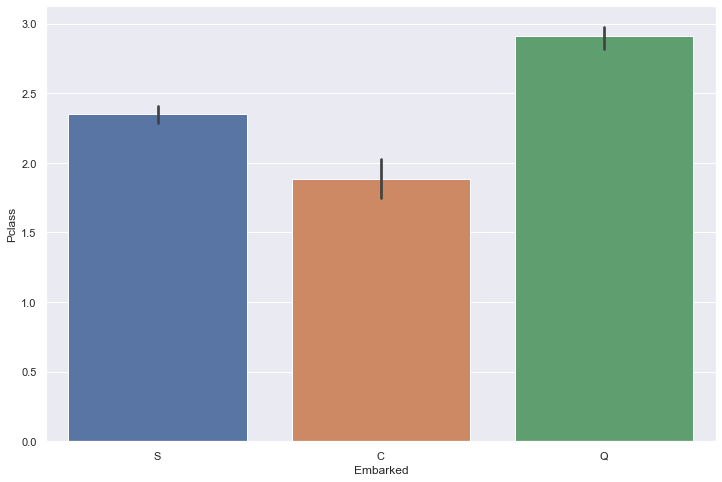

In [340]:
sns.barplot(x = "Embarked", y = "Pclass", data = data);

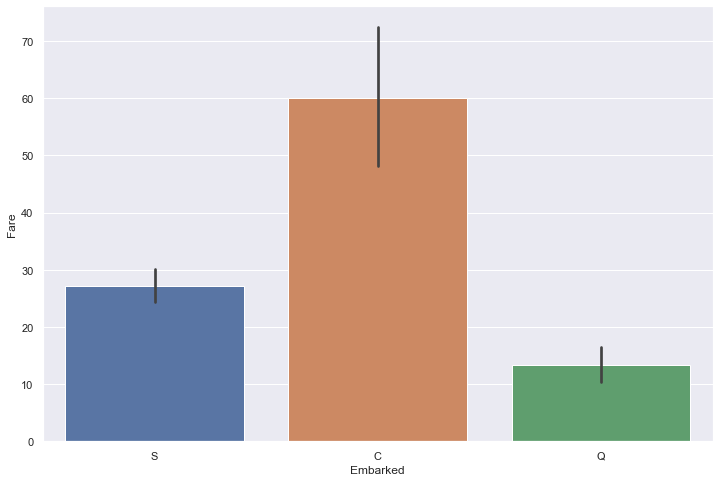

In [341]:
sns.barplot(x = "Embarked", y = "Fare", data = data);

У людей из Шербура действительно было больше денег. Но, что дело именно в этом, мы пока можем только предположить.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [929]:
data.shape[1]

17

In [930]:
data.isnull().mean()

Survived      0.000000
Pclass        0.000000
Name          0.000000
Sex           0.000000
Age           0.000000
SibSp         0.000000
Parch         0.000000
Ticket        0.000000
Fare          0.000000
Cabin         0.771044
Embarked      0.000000
Deck          0.000000
Cab_number    0.000000
Deck_num      0.000000
Embarked_C    0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [383]:
for column in data.columns:
    print('percentage of missing values in', column, 
          np.round((1- data[data[column].isnull()==False][column].count() / data.shape[0])*100,2)
         )

percentage of missing values in Survived 0.0
percentage of missing values in Pclass 0.0
percentage of missing values in Name 0.0
percentage of missing values in Sex 0.0
percentage of missing values in Age 19.87
percentage of missing values in SibSp 0.0
percentage of missing values in Parch 0.0
percentage of missing values in Ticket 0.0
percentage of missing values in Fare 0.0
percentage of missing values in Cabin 77.1
percentage of missing values in Embarked 0.22


**Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?**

**Age:** Возраст имеет распределение близкое к нормальному. И использовав для замены медиану, мы скорее всего не сильно исказим данные. Так было бы опасно делать, если бы возраст был самым значимым признаком, но выше мы видели, что это не так.

**Cabin:** Возможно, номер каюты содержит важную информацию. Например буква обозначает палубу. Шлюпки были над верхней палубой в центре судна. И наверное, меньше всего шансов было у тех, кто жил на нижних палубах на носу или корме. Можно было бы разобрать признак на два: палубу и номер. А для линейных моделей нужно еще номер преобразовать в удаленность от центра. Думаю, это бы хорошо сработало, будь у нас больше данных. На 23% данных тоже была бы прибавка к точности, но небольшая. Я решил совсем избавиться от признака, без обработки он бесполезен.

**upd.** Потом, все-таки решил попробовать использовать Cabin. У LR скор на тесте чуть вырос, у KNN - нет. Все же слишком мало данных.

Кстати, есть еще гипотеза, что если 3-4 человека жили в одной каюте, то это каюта низкого класса и это плохо для них. Но мы это и так поймем по Pclass.

**Embarked:** Пропущено всего два значения, можно выкинуть строки, можно сделать отдельный класс. Но, это всего два объекта. Заменю значения на наиболее популярные. Так проще будет кодировать признак.

**По поводу their  disadvantages.** Замена любых данных на синтетические потенциально ухудшает качество модели. Выбрасывание любых строк потенциально ухудьшает качество модели, если данных для обучения мало. Если данных достаточно - выбрасывать безопаснее.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def data_preparation(df):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    fare_99 = df["Fare"].quantile(0.99)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Fare'] = np.where(df['Fare']>fare_99,fare_99,df['Fare'])
    df['Cabin'] = df['Cabin'].replace(r'\s+','',regex=True)
    df['Cabin'] = np.where(df['Cabin'].str.len() > 4,df['Cabin'].str[-4:],df['Cabin'])
    df['Deck'] = df['Cabin'].fillna('00').astype(str).apply(lambda x: x[0]).astype(str)
    df['Cab_number'] = df['Cabin'].fillna('N0').astype(str).apply(lambda x: x[1:])
    df['Cab_number'] = pd.to_numeric(df['Cab_number'], errors='coerce').fillna(0).astype(int)
    
    # Перекодируем пол и порт посадки в числа. 
    df['Sex'] = df['Sex'].replace({"male":str(1),"female":str(0)}).astype(int)
    #data['Sex'] = data['Sex'].apply(lambda x: 0 if (x=='female') else 1)
    #data['Deck'] = data['Deck'].replace({"N":str(0)})
    df['Deck_num'] = LabelEncoder().fit_transform(df['Deck'])
    df[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = OneHotEncoder(
        ).fit_transform(np.array(df['Embarked']).reshape(-1, 1)).toarray()

data = pd.read_csv(os.path.join('./titanic/', 'train.csv')).set_index('PassengerId')
    
data_preparation(data)
data.head()

NameError: name 'pd' is not defined

In [924]:
target_column = 'Survived'
features = data.select_dtypes(include=[np.number]).columns.tolist()
features.remove(target_column)

#features.remove('Deck_num')
#features.remove('Cab_number')

X, y = data[features], data[target_column]

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [925]:
test_data = pd.read_csv(os.path.join('./titanic/', 'test.csv')).set_index('PassengerId')

data_preparation(test_data)
X_test = test_data[features]
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cab_number,Deck_num,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,0,0,0.0,1.0,0.0
893,3,0,47.0,1,0,7.0000,0,0,0.0,0.0,1.0
894,2,1,62.0,0,0,9.6875,0,0,0.0,1.0,0.0
895,3,1,27.0,0,0,8.6625,0,0,0.0,0.0,1.0
896,3,0,22.0,1,1,12.2875,0,0,0.0,0.0,1.0


In [926]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()

lr_pipe = make_pipeline(StandardScaler(), lr)
knn_pipe = make_pipeline(StandardScaler(), knn)

print(cross_val_score(lr_pipe, X, y, scoring='accuracy').mean())
print(cross_val_score(knn_pipe, X, y, scoring='accuracy').mean())

0.7934781244115248
0.8036093151716779


In [912]:
#params_knn = {'n_neighbors': np.arange(2,11), 'metric': ('euclidean', 'manhattan', 'chebyshev', 'minkowski')}
params_knn = {'n_neighbors': np.arange(2,21), 'metric': ('euclidean', 'manhattan', 'chebyshev', 'minkowski')}

knn_pipe = make_pipeline(StandardScaler(), 
    GridSearchCV(knn, param_grid=params_knn, refit=True, scoring='accuracy'))

knn_pipe.fit(X, y)
print(knn_pipe[1].best_score_)
print(knn_pipe[1].best_params_)

0.8193208210407381
{'metric': 'manhattan', 'n_neighbors': 11}


In [900]:
params_lr = {'C': np.arange(0.01,1,0.1), 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}

lr_pipe = make_pipeline(StandardScaler(), 
    GridSearchCV(lr, param_grid=params_lr, refit=True, scoring='accuracy'))

lr_pipe.fit(X, y)
print(lr_pipe[1].best_score_)
print(lr_pipe[1].best_params_)

0.7957190383528969
{'C': 0.11, 'solver': 'newton-cg'}


In [901]:
# c Deck
report_dict = classification_report(y, knn_pipe.predict(X), output_dict=True)
pd.DataFrame(report_dict)

,0,1,accuracy,macro avg,weighted avg
precision,0.857886,0.828025,0.847363,0.842956,0.846424
recall,0.901639,0.760234,0.847363,0.830937,0.847363
f1-score,0.879218,0.792683,0.847363,0.835951,0.846003
support,549.000000,342.000000,0.847363,891.000000,891.000000


In [902]:
report_dict = classification_report(y, lr_pipe.predict(X), output_dict=True)
pd.DataFrame(report_dict)

,0,1,accuracy,macro avg,weighted avg
precision,0.837456,0.769231,0.81257,0.803343,0.811268
recall,0.863388,0.730994,0.81257,0.797191,0.812570
f1-score,0.850224,0.749625,0.81257,0.799925,0.811610
support,549.000000,342.000000,0.81257,891.000000,891.000000


In [910]:
submission = pd.read_csv(os.path.join('./titanic/', 'gender_submission.csv')).set_index('PassengerId')
submission['Survived'] = lr_pipe.predict(X_test)
#submission

In [911]:
submission = pd.read_csv(os.path.join('./titanic/', 'gender_submission.csv')).set_index('PassengerId')
submission['Survived'] = knn_pipe.predict(X_test)
#submission

In [909]:
submission.to_csv('./my_submission_6_knn.csv')

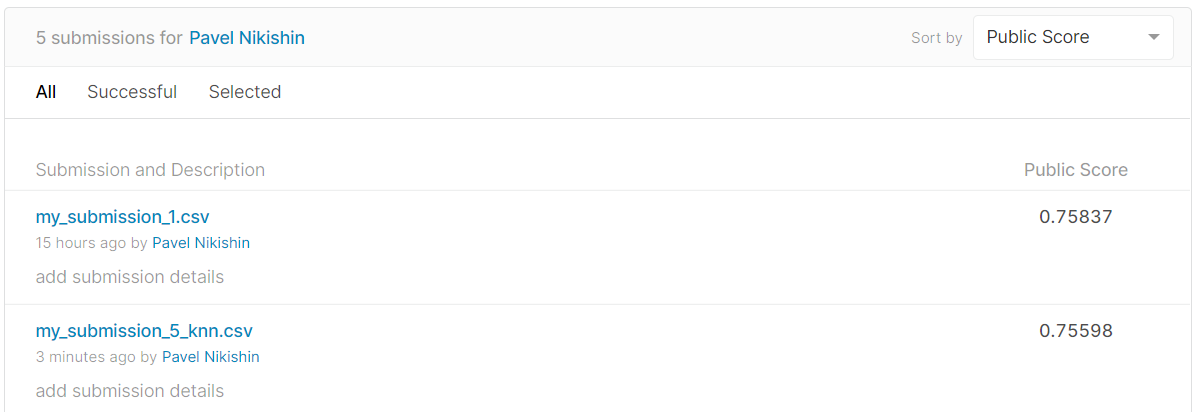

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.